In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
from scipy import misc
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse import csgraph
from scipy import linalg
from pysheds.grid import Grid
from scipy import ndimage
from matplotlib import colors
import seaborn as sns

import matplotlib
import matplotlib.cm as cm
from matplotlib.collections import LineCollection
import matplotlib.gridspec as gridspec

%matplotlib inline

In [2]:
sns.set_palette('husl', 2)

In [3]:
grid = Grid.from_raster('/home/mdbartos/Downloads/n30w100_dir/n30w100_dir',
                 data_name='dir')

In [4]:
grid.read_raster('/home/mdbartos/Downloads/n30w100_con/n30w100_con',
                 data_name='dem')

In [5]:
dirmap = (64,  128,  1,   2,    4,   8,    16,  32)

# Specify pour point
x, y = -97.294167, 32.73750

# Delineate the catchment
grid.catchment(data='dir', x=x, y=y, dirmap=dirmap, out_name='catch',
               recursionlimit=15000, xytype='label')
# Clip the bounding box to the catchment
grid.clip_to('catch', precision=5)

grid.accumulation(data='catch', dirmap=dirmap, pad_inplace=False, out_name='acc')

In [6]:
profiles, connections = grid.extract_profiles('catch', grid.acc > 25)

In [7]:
geom = grid.extract_river_network('catch', grid.acc > 25)

# Lo Diffusion + advection

In [8]:
dx = 60. * (np.asarray([profile.size for profile in profiles]) + 1)
n = max(max(connections.keys()), max(connections.values())) + 1
s = np.ones(n)
I = np.eye(n)
u = 1.0*np.ones(n)
D = (u * dx / 10).mean()*np.ones(n)
dt = 1
I[0, 0] = 0

U = np.zeros((n, n))
W = np.zeros((n, n))

for i, j in connections.items():
    # Confirmed as i
    U[j, i] = u[i] * dt / dx[i]
    W[i, j] = u[i] * dt / dx[i]
    
V = np.diag(W @ s)

X = np.zeros((n, n))

for i, j in connections.items():
    X[i, j] = 2 / (dx[i] + dx[j])
    X[j, i] = 2 / (dx[i] + dx[j])
    
Y = np.diag(X @ s)

Z = np.diag(D * dt / dx)
S = (U - V) - Z @ (Y - X) + I

In [9]:
np.imag(np.linalg.eig(S)[0]).max(), np.imag(np.linalg.eig(S)[0]).min(), np.real(np.linalg.eig(S)[0]).max(), np.real(np.linalg.eig(S)[0]).min()

(0.0, 0.0, 0.9997196165216445, -0.0027755206889173286)

In [10]:
C = np.eye(n)
ns = 11

In [11]:
W_c = linalg.solve_discrete_lyapunov(S, C)
st = np.argsort(np.diag(W_c))[::-1][:ns]

In [12]:
W_o = linalg.solve_discrete_lyapunov(S.T, C)

In [13]:
np.random.seed(0)
x0 = np.ones(S.shape[0])

In [14]:
from numba import njit

In [15]:
sr = np.asarray([  1, 128, 136,  52,  64,  92, 194,   9, 143, 161, 191,  13,  71,
       15, 125,  77, 141, 198,  58, 150, 102,  12,  88, 164, 204,   2,
       70,  87, 159, 177, 197,  22])

In [51]:
st = np.asarray([  5,   8,  14,  42,  26,  76,  51,  89,  45,  55,  63,  83,  28,
                   1,  65,  85, 104,  93, 103, 121, 115,  13,  11, 140,   9, 194,
                 107,   6,  71,  64,  31,  40])

In [16]:
@njit(fastmath=True)
def compute_multi_x0s(X0, S, C, T):
    Ac = np.eye(S.shape[0])
    Wo_r = np.zeros(S.shape)
    R_r = np.zeros(X0.shape)
    X0_hat = np.zeros(X0.shape)
    m = X0.shape[0]
    for _ in range(T):
        AC = C @ Ac
        Wo_r += (AC.T @ AC)
        for i in range(m):
            y = AC @ X0[i]
            R_r[i] += (AC.T @ y)
        Ac = S @ Ac
    Wo_r_inv = np.linalg.pinv(Wo_r)
    for i in range(m):
        X0_hat[i] = (Wo_r_inv @ R_r[i])
    return X0_hat

In [17]:
C = np.eye(S.shape[0])[sr[:11]]
X0 = np.vstack([x0, x0, x0, x0])

In [18]:
%time x0_hats = compute_multi_x0s(X0, S, C, 4000)

CPU times: user 25 s, sys: 8.48 s, total: 33.5 s
Wall time: 8.34 s


In [19]:
l, u = np.linalg.eigh(W_o)

In [20]:
X0 = (u.T).copy() # Copy to ensure contiguous array

In [21]:
start = time.time()
x0_hats = compute_multi_x0s(X0, S, C, 4000)
end = time.time()
print(end - start, ' s')

8.049846172332764  s


# Rank-based

In [22]:
C = np.eye(len(S))
X0_hats_r = {}

first_start = time.time()

for i in range(1, len(sr)):
    sensors = sr[:i].tolist()
    Ci = C[sensors]
    start = time.time()
    x0_hats_i = compute_multi_x0s(X0, S, Ci, 3600)
    end = time.time()
    print(f'{i}: ', end - start, ' s')
    X0_hats_r[i] = x0_hats_i
    
print('Total: ', end - first_start, ' s')

1:  5.284256935119629  s
2:  5.604048252105713  s
3:  5.931066513061523  s
4:  5.855987310409546  s
5:  6.206031084060669  s
6:  6.396489143371582  s
7:  6.588053226470947  s
8:  6.547013998031616  s
9:  6.853688478469849  s
10:  7.058967590332031  s
11:  7.608320474624634  s
12:  7.2649595737457275  s
13:  7.519898891448975  s
14:  7.5515382289886475  s
15:  8.013475179672241  s
16:  7.816910266876221  s
17:  8.053279876708984  s
18:  8.461242914199829  s
19:  8.686496496200562  s
20:  8.699692249298096  s
21:  9.078089952468872  s
22:  9.311627864837646  s
23:  9.358492612838745  s
24:  9.304436445236206  s
25:  9.608676195144653  s
26:  9.78682255744934  s
27:  10.081419706344604  s
28:  10.096417903900146  s
29:  10.241795539855957  s
30:  10.540703535079956  s
31:  10.745090961456299  s
Total:  250.19884610176086  s


# Trace-based

In [52]:
C = np.eye(len(S))
X0_hats_t = {}

first_start = time.time()

for i in range(1, len(st)):
    sensors = st[:i].tolist()
    Ci = C[sensors]
    start = time.time()
    x0_hats_i = compute_multi_x0s(X0, S, Ci, 3600)
    end = time.time()
    print(f'{i}: ', end - start, ' s')
    X0_hats_t[i] = x0_hats_i
    
print('Total: ', end - first_start, ' s')

1:  5.36166787147522  s
2:  5.609142541885376  s
3:  5.949307441711426  s
4:  5.888269662857056  s
5:  6.187980651855469  s
6:  6.3582305908203125  s
7:  6.666834831237793  s
8:  6.586530447006226  s
9:  6.773425579071045  s
10:  7.032038450241089  s
11:  7.221403360366821  s
12:  7.2124834060668945  s
13:  7.445376396179199  s
14:  7.616700649261475  s
15:  7.872602462768555  s
16:  7.726116180419922  s
17:  8.069507122039795  s
18:  8.475197553634644  s
19:  8.697243928909302  s
20:  8.705148458480835  s
21:  9.113528728485107  s
22:  9.33314323425293  s
23:  9.495540142059326  s
24:  9.336706399917603  s
25:  9.56959581375122  s
26:  9.899905920028687  s
27:  10.0374116897583  s
28:  10.060011863708496  s
29:  10.354948997497559  s
30:  10.53435230255127  s
31:  10.837984323501587  s
Total:  250.11494255065918  s


In [53]:
mse_by_num_sensors_r = np.asarray([((X0_hats_r[i] - X0)**2).sum() for i in range(1, 32)])
mse_by_num_sensors_t = np.asarray([((X0_hats_t[i] - X0)**2).sum() for i in range(1, 32)])

In [54]:
sns.set()

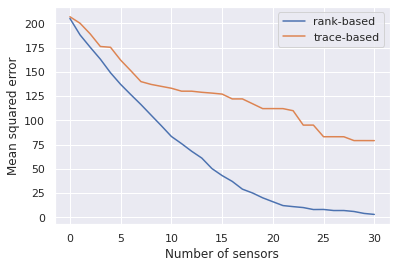

In [55]:
plt.plot(mse_by_num_sensors_r, label='rank-based')
plt.plot(mse_by_num_sensors_t, label='trace-based')
plt.xlabel('Number of sensors')
plt.ylabel('Mean squared error')
plt.legend()

In [56]:
mse_by_mode_r = sum([((X0_hats_r[i] - X0)**2).sum(axis=1) for i in range(1, 32)])
mse_by_mode_t = sum([((X0_hats_t[i] - X0)**2).sum(axis=1) for i in range(1, 32)])

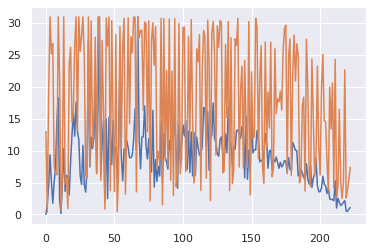

In [57]:
plt.plot(mse_by_mode_r)
plt.plot(mse_by_mode_t)

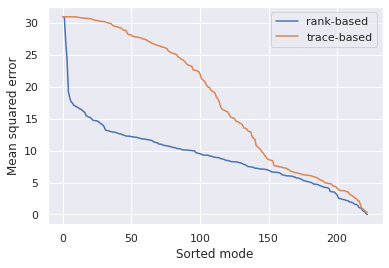

In [59]:
plt.plot(np.sort(mse_by_mode_r)[::-1], label='rank-based')
plt.plot(np.sort(mse_by_mode_t)[::-1], label='trace-based')
plt.xlabel('Sorted mode')
plt.ylabel('Mean squared error')
plt.legend()

In [39]:
mse_by_mode_by_num_sensors = np.column_stack([((X0_hats_r[i] - X0)**2).sum(axis=1) for i in range(1, 32)])

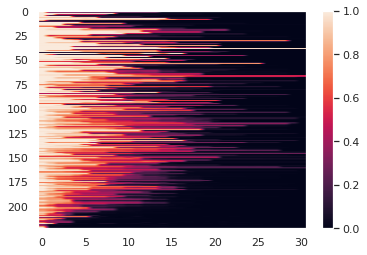

In [49]:
plt.imshow(mse_by_mode_by_num_sensors, zorder=1, aspect='auto')
plt.colorbar()

In [60]:
import pickle

In [63]:
with open('X0_hat_r.p', 'wb') as outfile:
    pickle.dump(X0_hats_r, outfile)

In [64]:
with open('X0_hat_t.p', 'wb') as outfile:
    pickle.dump(X0_hats_t, outfile)

# Laplacian

In [68]:
Adj = np.zeros((n, n))

for i, j in connections.items():
    # Confirmed as i
    Adj[j, i] = 1
    Adj[i, j] = 1
    
Lap = sparse.csgraph.laplacian(Adj)

In [69]:
l, u = np.linalg.eigh(Lap)

In [70]:
X0 = (u.T).copy() # Copy to ensure contiguous array

In [71]:
C = np.eye(len(S))
X0_hats_rl = {}

first_start = time.time()

for i in range(1, len(sr)):
    sensors = sr[:i].tolist()
    Ci = C[sensors]
    start = time.time()
    x0_hats_i = compute_multi_x0s(X0, S, Ci, 3600)
    end = time.time()
    print(f'{i}: ', end - start, ' s')
    X0_hats_rl[i] = x0_hats_i
    
print('Total: ', end - first_start, ' s')

1:  5.811061382293701  s
2:  5.748872518539429  s
3:  5.994388103485107  s
4:  5.859962224960327  s
5:  6.432956695556641  s
6:  6.4761061668396  s
7:  6.638822793960571  s
8:  6.597306966781616  s
9:  6.946418046951294  s
10:  6.972985029220581  s
11:  7.35770058631897  s
12:  7.288097858428955  s
13:  7.547632217407227  s
14:  7.717936754226685  s
15:  7.884153842926025  s
16:  7.823932409286499  s
17:  8.278745174407959  s
18:  11.566749095916748  s
19:  11.470829248428345  s
20:  9.952150821685791  s
21:  10.640655517578125  s
22:  10.559753656387329  s
23:  9.426468849182129  s
24:  9.42043161392212  s
25:  9.765192031860352  s
26:  9.818683385848999  s
27:  10.191755056381226  s
28:  10.134028434753418  s
29:  10.372632026672363  s
30:  10.562698602676392  s
31:  11.085272073745728  s
Total:  262.37032675743103  s


In [72]:
C = np.eye(len(S))
X0_hats_tl = {}

first_start = time.time()

for i in range(1, len(st)):
    sensors = st[:i].tolist()
    Ci = C[sensors]
    start = time.time()
    x0_hats_i = compute_multi_x0s(X0, S, Ci, 3600)
    end = time.time()
    print(f'{i}: ', end - start, ' s')
    X0_hats_tl[i] = x0_hats_i
    
print('Total: ', end - first_start, ' s')

1:  5.311589241027832  s
2:  5.633098125457764  s
3:  5.969622611999512  s
4:  5.789129018783569  s
5:  6.246241092681885  s
6:  6.3878772258758545  s
7:  6.659742593765259  s
8:  6.565660238265991  s
9:  6.879842042922974  s
10:  7.015946388244629  s
11:  7.24481463432312  s
12:  7.402357578277588  s
13:  7.461438894271851  s
14:  7.591068267822266  s
15:  7.858867168426514  s
16:  7.85265851020813  s
17:  8.02223253250122  s
18:  8.363713502883911  s
19:  8.620128870010376  s
20:  8.73860764503479  s
21:  8.952865600585938  s
22:  9.105501651763916  s
23:  9.391759157180786  s
24:  9.467175960540771  s
25:  9.611571311950684  s
26:  9.772849559783936  s
27:  10.060805797576904  s
28:  10.039178133010864  s
29:  10.255324363708496  s
30:  10.553652048110962  s
31:  10.926508665084839  s
Total:  249.77420568466187  s


In [76]:
mse_by_num_sensors_rl = np.asarray([((X0_hats_rl[i] - X0)**2).sum() for i in range(1, 32)])
mse_by_num_sensors_tl = np.asarray([((X0_hats_tl[i] - X0)**2).sum() for i in range(1, 32)])

In [77]:
mse_by_mode_rl = sum([((X0_hats_rl[i] - X0)**2).sum(axis=1) for i in range(1, 32)])
mse_by_mode_tl = sum([((X0_hats_tl[i] - X0)**2).sum(axis=1) for i in range(1, 32)])

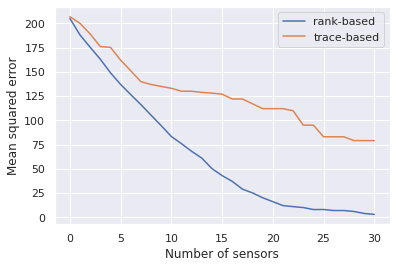

In [78]:
plt.plot(mse_by_num_sensors_rl, label='rank-based')
plt.plot(mse_by_num_sensors_tl, label='trace-based')
plt.xlabel('Number of sensors')
plt.ylabel('Mean squared error')
plt.legend()

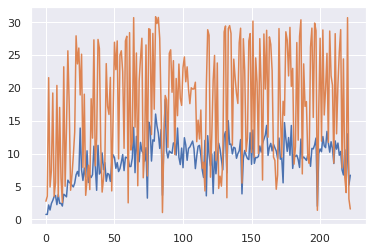

In [79]:
plt.plot(mse_by_mode_rl)
plt.plot(mse_by_mode_tl)

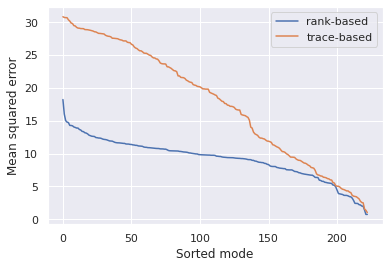

In [80]:
plt.plot(np.sort(mse_by_mode_rl)[::-1], label='rank-based')
plt.plot(np.sort(mse_by_mode_tl)[::-1], label='trace-based')
plt.xlabel('Sorted mode')
plt.ylabel('Mean squared error')
plt.legend()